# Master1 - Empirical fMRI analyses, each task separately (use all 7 tasks together)

## Takuya Ito
#### 01/07/2019

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import sklearn
import seaborn as sns
plt.style.use("ggplot")
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "FreeSans"
import nibabel as nib
import pandas as pd
import sys
sys.path.append('glmScripts/')
import taskGLMPipeline as tgp
import h5py
import dimensionality
sys.path.append('bctpy/')
import bct

## Set-up subject list and construct global variables

In [3]:
## All subjects
subjNums = ['178950','189450','199453','209228','220721','298455','356948','419239','499566','561444','618952','680452','757764','841349','908860',
            '103818','113922','121618','130619','137229','151829','158035','171633','179346','190031','200008','210112','221319','299154','361234',
            '424939','500222','570243','622236','687163','769064','845458','911849','104416','114217','122317','130720','137532','151930','159744',
            '172029','180230','191235','200614','211316','228434','300618','361941','432332','513130','571144','623844','692964','773257','857263',
            '926862','105014','114419','122822','130821','137633','152427','160123','172938','180432','192035','200917','211417','239944','303119',
            '365343','436239','513736','579665','638049','702133','774663','865363','930449','106521','114823','123521','130922','137936','152831',
            '160729','173334','180533','192136','201111','211619','249947','305830','366042','436845','516742','580650','645450','715041','782561',
            '871762','942658','106824','117021','123925','131823','138332','153025','162026','173536','180735','192439','201414','211821','251833',
            '310621','371843','445543','519950','580751','647858','720337','800941','871964','955465','107018','117122','125222','132017','138837',
            '153227','162329','173637','180937','193239','201818','211922','257542','314225','378857','454140','523032','585862','654350','725751',
            '803240','872562','959574','107422','117324','125424','133827','142828','153631','164030','173940','182739','194140','202719','212015',
            '257845','316633','381543','459453','525541','586460','654754','727553','812746','873968','966975','100206','108020','117930','126325','133928','143224','153934','164636','174437','183034','194443','204521','212823','268749','322224',
            '385450','463040','529953','587664','656253','731140','814548','877269','978578','100408','108222','118124','126426','134021','144832',
            '154229','164939','175338','185139','194645','204622','213017','268850','329844','389357','467351','530635','588565','657659','737960',
            '816653','878877','987074','101006','110007','118225','127933','134324','146331','154532','165638','175742','185341','195445','205119',
            '213421','274542','341834','393247','479762','545345','597869','664757','742549','820745','887373','989987','102311','111009','118831',
            '128632','135528','146432','154936','167036','176441','186141','196144','205725','213522','285345','342129','394956','480141','552241',
            '598568','671855','744553','826454','896879','990366','102513','112516','118932','129028','135629','146533','156031','167440','176845',
            '187850','196346','205826','214423','285446','348545','395756','481042','553344','599671','675661','749058','832651','899885','991267',
            '102614','112920','119126','129129','135932','147636','157336','168745','177645','188145','198350','208226','214726','286347','349244',
            '406432','486759','555651','604537','679568','749361','835657','901442','992774','103111','113316','120212','130013','136227','148133',
            '157437','169545','178748','188549','198451','208327','217429','290136','352738','414229','497865','559457','615744','679770','753150',
            '837560','907656','993675','103414','113619','120414','130114','136833','150726','157942','171330']



basedir = '/projects3/TaskFCMech/'

# Using final partition
networkdef = np.loadtxt('/projects3/NetworkDiversity/data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = '/projects/AnalysisTools/ParcelsGlasser2016/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(xticks.keys())
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

tasks = {'EMOTION':[0,1],
     'GAMBLING':[2,3],
     'LANGUAGE':[4,5],
     'MOTOR':[6,7,8,9,10,11],
     'RELATIONAL':[12,13],
     'SOCIAL':[14,15],
     'WM':[16,17,18,19,20,21,22,23]}
taskNames = ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
TRsPerRun = [176,176,253,253,316,316,284,284,232,232,274,274,405,405]
restRuns = ['rfMRI_REST1_RL', 'rfMRI_REST1_LR','rfMRI_REST2_RL', 'rfMRI_REST2_LR']
taskRuns= ['tfMRI_EMOTION_RL','tfMRI_EMOTION_LR','tfMRI_GAMBLING_RL','tfMRI_GAMBLING_LR',
           'tfMRI_LANGUAGE_RL','tfMRI_LANGUAGE_LR','tfMRI_MOTOR_RL','tfMRI_MOTOR_LR',
           'tfMRI_RELATIONAL_RL','tfMRI_RELATIONAL_LR','tfMRI_SOCIAL_RL','tfMRI_SOCIAL_LR','tfMRI_WM_RL','tfMRI_WM_LR']

# 0.0 Define functions for loading data

In [4]:
def loadRestResiduals(subj,model='24pXaCompCorXVolterra',zscore=False,FIR=False):
    datafile = '/projects3/TaskFCMech/data/hcppreprocessedmsmall/hcpPostProcCiric/' + subj + '_glmOutput_data.h5' 
    h5f = h5py.File(datafile,'r')
    data = []
    if FIR:
        dataid = 'rfMRI_REST_' + model + '_taskReg_resid_FIR'
        data = h5f['taskRegression'][dataid][:]
        if zscore:
            # Zscore each run separately
            runstart = 0
            for run in range(4):
                runend = runstart + 1195
                data[:,runstart:runend] = stats.zscore(data[:,runstart:runend],axis=1)
                runstart += 1195
                
            # Now z-score rest time series as if it were task
            trcount = 0
            for ntrs in TRsPerRun:
                trstart = trcount
                trend = trcount + ntrs
                data[:,trstart:trend] = stats.zscore(data[:,trstart:trend],axis=1)

                trcount += ntrs

        data = data.T
    else:
        for run in restRuns:
            dataid = run + '/nuisanceReg_resid_' + model
            tmp = h5f[dataid][:]
            tmp = stats.zscore(tmp,axis=1)
            data.extend(tmp.T)
    data = np.asarray(data).T
    h5f.close()
    return data

def loadTaskActivity(subj,model='24pXaCompCorXVolterra',zscore=False):
    datafile = '/projects3/TaskFCMech/data/hcppreprocessedmsmall/hcpPostProcCiric/' + subj + '_glmOutput_data.h5' 
    h5f = h5py.File(datafile,'r')
    betas = []
    for task in taskNames:
        dataid = 'tfMRI_' + task + '_' + model + '_taskReg_betas_canonical'
        tmp = h5f['taskRegression'][dataid][:]
        betas.extend(tmp[:,1:].T)
    betas = np.asarray(betas).T
    h5f.close()
    return betas

def loadTaskResiduals(subj, model='24pXaCompCorXVolterra', taskModel='FIR', zscore=False):
    datafile = '/projects3/TaskFCMech/data/hcppreprocessedmsmall/hcpPostProcCiric/' + subj + '_glmOutput_data.h5'         
    h5f = h5py.File(datafile,'r')
    resids = []
    for task in taskNames:
        dataid = 'tfMRI_' + task + '_' + model + '_taskReg_resid_' + taskModel
        tmp = h5f['taskRegression'][dataid][:]
        if zscore:
            nTRsPerRun = tmp.shape[1]/2
            tmp[:,:nTRsPerRun] = stats.zscore(tmp[:,:nTRsPerRun],axis=1)
            tmp[:,nTRsPerRun:] = stats.zscore(tmp[:,nTRsPerRun:],axis=1)
        resids.extend(tmp.T)
    resids = np.asarray(resids).T
    h5f.close()
    return resids

### Main parameters

In [5]:
model = '24pXaCompCorXVolterra'
zscore = True
FIR = True

# 1.0 Identify number of significantly active regions for each task, relative to 0

## 1.1 First load task activation data

In [6]:
nTasks = 24
taskActivity = np.zeros((nParcels,nTasks,len(subjNums)))
scount = 0
for subj in subjNums:
    taskActivity[:,:,scount] = loadTaskActivity(subj, model=model, zscore=zscore)
    scount += 1

## Load rest and task data time series

In [7]:
nTasks = 7
nCond = 24
restTS = np.zeros((nParcels,4780,len(subjNums)))
restTS = np.zeros((nParcels,3810,len(subjNums)))
taskTS = np.zeros((nParcels,3810,len(subjNums)))
task_specific_timing = np.zeros((3810,nTasks,len(subjNums)))
scount = 0
for subj in subjNums:
    if scount%25==0: print 'Loading in data for subject', scount+1, '/', len(subjNums)
    restTS[:,:,scount] = loadRestResiduals(subj,model=model,zscore=zscore,FIR=FIR)
    taskTS[:,:,scount] = loadTaskResiduals(subj, model=model, taskModel='FIR', zscore=zscore) # We make this FIR since we only want to use FIR regressed task residuals for FC analysis
    tmp_timing_all = tgp.loadTaskTimingForAllTasks(subj,taskModel='canonical')['taskRegressors']>.5 # Only to obtain which time points to estimate FC with
    
    taskcount = 0
    for task in taskNames:
        task_ind = tasks[task]
        tmp_timing = tmp_timing_all[:,task_ind]
        task_specific_timing[:,taskcount,scount] = np.sum(tmp_timing,axis=1)>0
        taskcount += 1
    scount += 1
    
task_specific_timing = task_specific_timing.astype(bool)

Loading in data for subject 1 / 352
Loading in data for subject 26 / 352
Loading in data for subject 51 / 352
Loading in data for subject 76 / 352
Loading in data for subject 101 / 352
Loading in data for subject 126 / 352
Loading in data for subject 151 / 352
Loading in data for subject 176 / 352
Loading in data for subject 201 / 352
Loading in data for subject 226 / 352
Loading in data for subject 251 / 352
Loading in data for subject 276 / 352
Loading in data for subject 301 / 352
Loading in data for subject 326 / 352
Loading in data for subject 351 / 352


# 1.0 *Hypothesis*: From rest to task states, there will be more quenching of correlated variability (and overall variability)

#### Group-averaged analysis (each task separately)

## Compute task-specific FC and compare to rest

EMOTION task versus rest, global dimensionality 	 Dim diff = 10.354020079363146
	 t = 22.005969558695902 | p = $p < 0.0001$
	Number of FC Increases: 4.944289693593315
	Number of FC Decreases: 78.40916125038687
GAMBLING task versus rest, global dimensionality 	 Dim diff = 14.641798914352481
	 t = 26.871625502887728 | p = $p < 0.0001$
	Number of FC Increases: 12.19900959455277
	Number of FC Decreases: 70.48901268956979
LANGUAGE task versus rest, global dimensionality 	 Dim diff = 12.399350021838796
	 t = 20.47811482064308 | p = $p < 0.0001$
	Number of FC Increases: 11.185391519653358
	Number of FC Decreases: 74.32528628907458
MOTOR task versus rest, global dimensionality 	 Dim diff = 7.3300518180948835
	 t = 14.473215853892828 | p = $p < 0.0001$
	Number of FC Increases: 15.745899102445064
	Number of FC Decreases: 57.31662024141133
RELATIONAL task versus rest, global dimensionality 	 Dim diff = 13.313808118215235
	 t = 23.53384052513766 | p = $p < 0.0001$
	Number of FC Increases: 7.332095

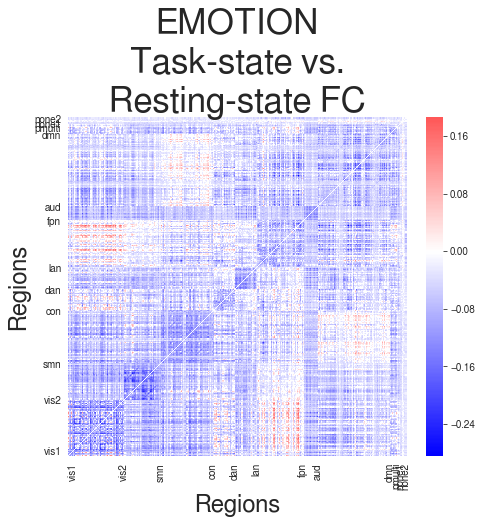

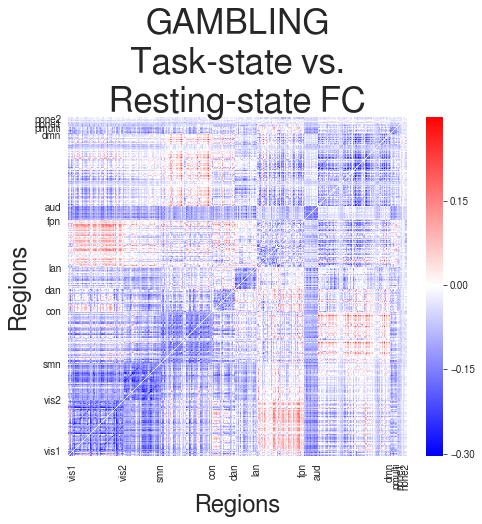

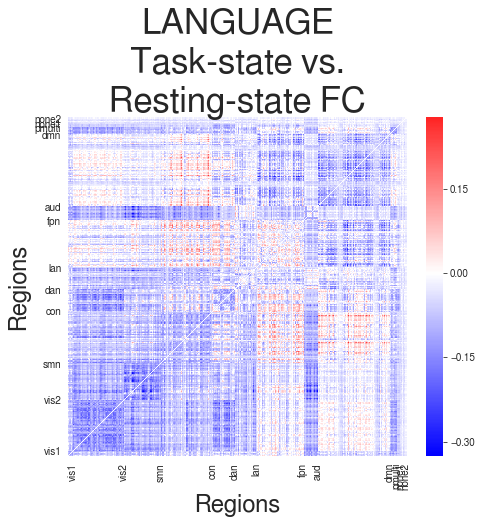

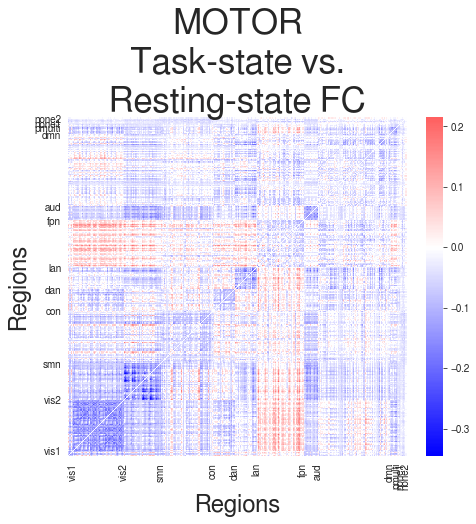

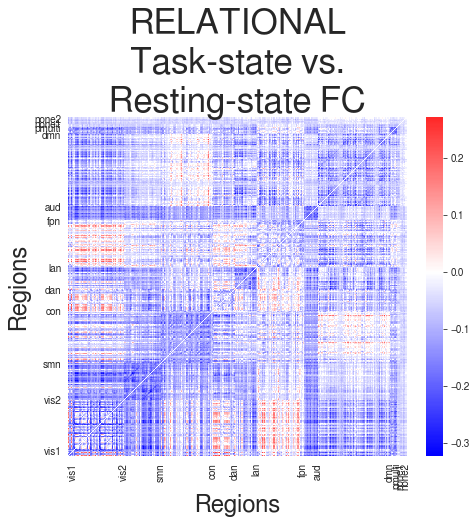

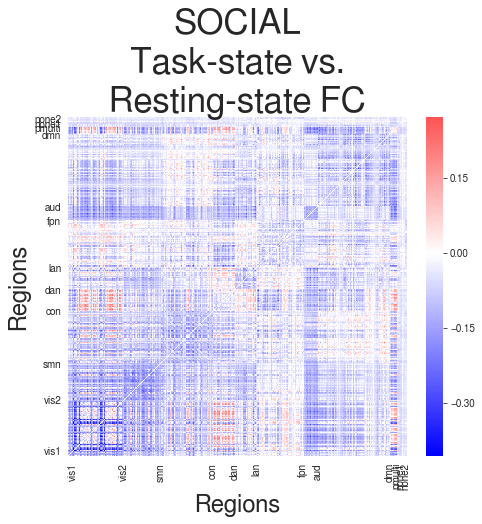

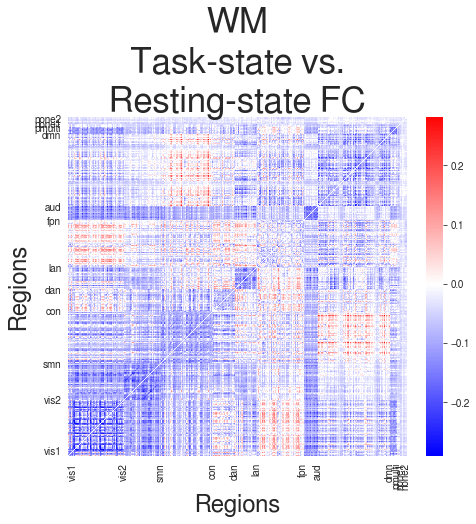

In [15]:
df_dimensionality = {}
df_dimensionality['State'] = []
df_dimensionality['Subject'] = []
df_dimensionality['Dimensionality'] = []
df_dimensionality['Task'] = []
taskcount = 0
for task in taskNames:
#     df_dimensionality = {}
#     df_dimensionality['State'] = []
#     df_dimensionality['Subject'] = []
#     df_dimensionality['Dimensionality'] = []
    
    taskSpecificFC = np.zeros((nParcels,nParcels,len(subjNums)))
    restSpecificFC = np.zeros((nParcels,nParcels,len(subjNums)))
    tmprest = []
    tmptask = []
    for s in range(len(subjNums)):

        taskSpecificFC[:,:,s] = np.corrcoef(taskTS[:,task_specific_timing[:,taskcount,s],s])
        np.fill_diagonal(taskSpecificFC[:,:,s],0)

        restSpecificFC[:,:,s] = np.corrcoef(restTS[:,task_specific_timing[:,taskcount,s],s])
        np.fill_diagonal(restSpecificFC[:,:,s],0)

        df_dimensionality['State'].append('Rest')
        df_dimensionality['Subject'].append(subjNums[s])
        tmp = np.cov(restTS[:,task_specific_timing[:,taskcount,s],s])
        tmp_dim = dimensionality.getDimensionality(tmp)
        df_dimensionality['Dimensionality'].append(tmp_dim)
        tmprest.append(tmp_dim)
        df_dimensionality['Task'].append(task)

        df_dimensionality['State'].append('Task')
        df_dimensionality['Subject'].append(subjNums[s])
        tmp = np.cov(taskTS[:,task_specific_timing[:,taskcount,s],s])
        tmp_dim = dimensionality.getDimensionality(tmp)
        df_dimensionality['Dimensionality'].append(tmp_dim)
        tmptask.append(tmp_dim)
        df_dimensionality['Task'].append(task)

    # Fz transform
    taskSpecificFC = np.arctanh(taskSpecificFC)
    restSpecificFC = np.arctanh(restSpecificFC)

    groupStatsFC = np.zeros((nParcels,nParcels,3))
    groupStatsFC[:,:,0], groupStatsFC[:,:,1] = stats.ttest_rel(taskSpecificFC,restSpecificFC,axis=2)

    # FDR-correction
    triu_ind = np.triu_indices(nParcels,k=1)
    groupStatsFC[:,:,2][triu_ind] = mc.fdrcorrection0(groupStatsFC[:,:,1][triu_ind])[0]
    groupStatsFC[:,:,2] = groupStatsFC[:,:,2] + groupStatsFC[:,:,2].T
    np.fill_diagonal(groupStatsFC[:,:,1],1) # diagonal p-value should be
    
    
    #### Plotting
    ## Dimensionality plotting
#     tmp_df = pd.DataFrame(df_dimensionality)

#     # Draw a nested boxplot to show bills by day and time
#     plt.figure(figsize=(5,5))
#     tmprest = df_dimensionality.loc[tmp_df['State']=='Rest']
#     tmptask = df_dimensionality.loc[tmp_df['State']=='Task']
    t, p = stats.ttest_rel(tmptask,tmprest)

#     sns.boxplot(data=[tmprest['Dimensionality'],tmptask['Dimensionality']],
#                palette=["#add8e6","#f08080"],
#                meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
#                medianprops={'linestyle':'-'},sym='',whis=0)
#     sns.swarmplot(data=[tmprest['Dimensionality'],tmptask['Dimensionality']],
#                 palette=["#add8e6","#f08080"],
#                 alpha=0.5)
    if str(round(p,3))=="0.0": 
        p = '$p < 0.0001$'
    else:
        p = '$p = ' + str(round(p,3))
#     plt.title(task + ' task vs. rest\nGlobal dimensionality',fontsize=28,fontname='FreeSans')
#     # plt.title('Task versus Rest\nWhole-brain dimensionality\n$t_{175} = ' + str(round(t,3)) + '$ | ' + p,fontsize=24,fontname='FreeSans')
#     plt.ylabel('Dimensionality',fontsize=24)
#     plt.xlabel('State',fontsize=24)
#     plt.xticks(np.arange(2),['Rest','Task'],fontname='FreeSans',fontsize=18)
#     plt.ylim([np.min(df_dimensionality['Dimensionality'])-np.std(df_dimensionality['Dimensionality']),np.max(df_dimensionality['Dimensionality'])+2*np.std(df_dimensionality['Dimensionality'])]);
#     plt.yticks(fontsize=18)
#     plt.tight_layout()
#     plt.savefig('fMRI3_' + task + '_GlobalDimensionality_Exploratory.pdf')

    print task, 'task versus rest, global dimensionality',
#     print '\t Dim diff =', np.mean(tmptask['Dimensionality']) - np.mean(tmprest['Dimensionality'])
    print '\t Dim diff =', np.mean(tmptask) - np.mean(tmprest)
    print '\t t =', t, '| p =', p
    
    
    ## FC difference plotting 
#     plt.figure(figsize=(21,7))
#     plt.subplot(131)
    tmptask = np.tanh(np.mean(taskSpecificFC,axis=2))
#     # sigFC = np.multiply(rest[:,:,0],groupStatsFC[:,:,2])
#     ax = sns.heatmap(tmptask[networkorder,networkorder.T],square=True,center=0, vmin=-.1, vmax=.75, cmap='bwr',cbar=True,cbar_kws={'fraction':0.046})
#     plt.xticks(xticks.keys(),xticks.values());
#     plt.yticks(xticks.keys(),xticks.values());
#     plt.xlabel('Regions',fontsize=24)
#     plt.ylabel('Regions',fontsize=24)
#     plt.title(task + '\nTask-state FC',fontsize=35)
#     ax.invert_yaxis()
#     # print np.sum(sigFC)

#     plt.subplot(132)
    tmprest = np.tanh(np.mean(restSpecificFC,axis=2))
#     # sigFC = np.multiply(rest[:,:,0],groupStatsFC[:,:,2])
#     ax = sns.heatmap(tmprest[networkorder,networkorder.T],square=True,center=0,cmap='bwr',vmin=-.1, vmax=.75, cbar=True,cbar_kws={'fraction':0.046})
#     plt.xticks(xticks.keys(),xticks.values());
#     plt.yticks(xticks.keys(),xticks.values());
#     plt.xlabel('Regions',fontsize=24)
#     plt.ylabel('Regions',fontsize=24)
#     plt.title('Resting-state FC',fontsize=35)
#     ax.invert_yaxis()

#     plt.subplot(133)
#     plt.figure(figsize=(7,7))
#     # sigFC = np.multiply(groupStatsFC[:,:,0],groupStatsFC[:,:,2])
#     sigFC = np.multiply(tmptask-tmprest,groupStatsFC[:,:,2])
#     ax = sns.heatmap(sigFC[networkorder,networkorder.T],square=True,center=0,cmap='bwr', cbar=True,cbar_kws={'fraction':0.046})
#     plt.xticks(xticks.keys(),xticks.values());
#     plt.yticks(xticks.keys(),xticks.values());
#     plt.xlabel('Regions',fontsize=24)
#     plt.ylabel('Regions',fontsize=24)
#     plt.title(task + '\nTask-state vs.\nResting-state FC',fontsize=35)
#     ax.invert_yaxis()
#     plt.tight_layout()
#     plt.savefig('fMRI3_' + task + '_TaskRestFC_Exploratory.pdf')
    
    
    totalConn = (nParcels*nParcels)-nParcels
    posFC = np.sum(np.multiply(groupStatsFC[:,:,0]>0,groupStatsFC[:,:,2]))/totalConn*100
    negFC = np.sum(np.multiply(groupStatsFC[:,:,0]<0,groupStatsFC[:,:,2]))/totalConn*100

    print '\tNumber of FC Increases:', posFC
    print '\tNumber of FC Decreases:', negFC
    # print '\tPos-Neg Ratio =', posFC/negFC

#     plt.figure(figsize=(7,5))
#     sns.barplot(x=np.arange(2),y=[posFC,negFC])
#     plt.xticks(np.arange(2),['FC Increases', 'FC Decreases'],fontsize=24)
#     plt.ylabel('Percent of FC changes',fontsize=24)
#     plt.yticks(fontsize=20)
#     plt.title(task + '\nPercent of significant\nFC changes', y=1.03,fontsize=30)
#     plt.tight_layout()
#     plt.savefig('fMRI3_' + task + '_NumberFCChanges_Exploratory.pdf')
    
    taskcount += 1
    
    

df_dimensionality = pd.DataFrame(df_dimensionality)

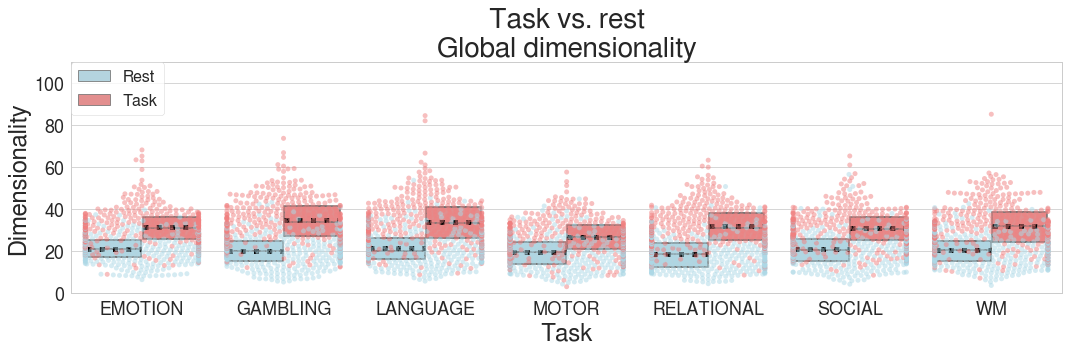

In [9]:

plt.figure(figsize=(15,5))
sns.boxplot(x='Task', y='Dimensionality', hue='State', data=df_dimensionality,
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
ax = sns.swarmplot(x='Task', y='Dimensionality', hue='State', data=df_dimensionality,
            palette=["#add8e6","#f08080"],
            alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],borderaxespad=0.,fontsize=16)
plt.title('Task vs. rest\nGlobal dimensionality',fontsize=28,fontname='FreeSans')
# plt.title('Task versus Rest\nWhole-brain dimensionality\n$t_{175} = ' + str(round(t,3)) + '$ | ' + p,fontsize=24,fontname='FreeSans')
plt.ylabel('Dimensionality',fontsize=24)
plt.xlabel('Task',fontsize=24)
plt.xticks(np.arange(len(taskNames)),taskNames,fontname='FreeSans',fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0,110])
plt.tight_layout()
plt.savefig('fMRI3_7Task_GlobalDimensionality.pdf')



In [10]:
nproc = 20
# taskRestFCDiff = np.zeros((nParcels,len(tasks),3)) # t-stat, p-value, q-value
# taskFC = np.zeros((nParcels,nParcels,len(tasks),len(subjNums))) # From task time series using FIR regressed data
# restFC = np.zeros((nParcels,nParcels,len(tasks),len(subjNums))) # From rest time series, but using FIR regressed rest timings
# FC_change_stats = np.zeros((nParcels,nParcels,len(tasks),3)) # p and q values

# taskSD = np.zeros((nParcels,len(tasks),len(subjNums))) # From task time series using FIR regressed data
# restSD = np.zeros((nParcels,len(tasks),len(subjNums))) # From rest time series, but using FIR regressed rest timings

# nCond = 24

taskRestFCDiff = np.zeros((nParcels,len(tasks),3)) # t-stat, p-value, q-value
taskFC = np.zeros((nParcels,nParcels,len(tasks),len(subjNums))) # From task time series using FIR regressed data
restFC = np.zeros((nParcels,nParcels,len(tasks),len(subjNums))) # From rest time series, but using FIR regressed rest timings
FC_change_stats = np.zeros((nParcels,nParcels,len(tasks),3)) # p and q values

taskSD = np.zeros((nParcels,len(tasks),len(subjNums))) # From task time series using FIR regressed data
restSD = np.zeros((nParcels,len(tasks),len(subjNums))) # From rest time series, but using FIR regressed rest timings

def computeFC(data):
    fc = np.corrcoef(data)
    np.fill_diagonal(fc,0)
    fc = np.arctanh(fc)
    return fc

task = 0
for t in taskNames:
    task_ind = tasks[t]
    
    inputsRest = []
    inputsTask = []
    scount = 0
    for subj in subjNums:
        tasktime = task_specific_timing[:,task,scount] # isolate task
#         tasktime = task_timing[:,task,scount] # isolate task
        
        
#         taskSD[:,task,scount] = np.std(taskTS[:,tasktime,scount],axis=1)
#         restSD[:,task,scount] = np.std(restTS[:,tasktime,scount],axis=1)
#         taskmean = np.mean(taskTS[:,tasktime,scount],axis=1)
#         taskmean.shape = (len(taskmean),1)
#         restmean = np.mean(restTS[:,tasktime,scount],axis=1)
#         restmean.shape = (len(restmean),1)
#         taskSD[:,task,scount] = np.mean((taskTS[:,tasktime,scount]-taskmean)**2,axis=1)
#         restSD[:,task,scount] = np.mean((restTS[:,tasktime,scount]-restmean)**2,axis=1)
        
        taskSD[:,task,scount] = np.var(taskTS[:,task_specific_timing[:,task,s],scount],axis=1)
        restSD[:,task,scount] = np.var(restTS[:,task_specific_timing[:,task,s],scount],axis=1)
        # Fano factor
#         taskSD[:,task,scount] = np.divide(np.std(taskTS[:,tasktime,scount],axis=1)**2,np.mean(taskActivity[:,task_ind,scount],axis=1))
#         restSD[:,task,scount] = np.divide(np.std(restTS[:,tasktime,scount],axis=1)**2,np.mean(taskActivity[:,task_ind,scount],axis=1))
        
        inputsRest.append(restTS[:,task_specific_timing[:,task,s],scount])
        inputsTask.append(taskTS[:,task_specific_timing[:,task,s],scount])
        
        scount += 1
        
    pool = mp.Pool(processes=nproc)
    resultsRest = pool.map_async(computeFC,inputsRest).get()
    pool.close()
    pool.join()
    
    pool = mp.Pool(processes=nproc)
    resultsTask = pool.map_async(computeFC,inputsTask).get()
    pool.close()
    pool.join()
    
    for s in range(len(subjNums)):
        restFC[:,:,task,s] = resultsRest[s]
        taskFC[:,:,task,s] = resultsTask[s]
    
    t, p = stats.ttest_rel(taskFC[:,:,task,:], restFC[:,:,task,:],axis=2)
    FC_change_stats[:,:,task,0] = np.tanh(np.mean(taskFC[:,:,task,:] - restFC[:,:,task,:],axis=2))
    FC_change_stats[:,:,task,1] = p
    np.fill_diagonal(FC_change_stats[:,:,task,1],1.0) # diagonal should have p=1.0
    
    # Perform FDR-correction on changed connections
    triu_ind = np.triu_indices(nParcels,k=1)
    FC_change_stats[:,:,task,2][triu_ind] = mc.fdrcorrection0(FC_change_stats[:,:,task,1][triu_ind])[0]
    FC_change_stats[:,:,task,2] = FC_change_stats[:,:,task,2] + FC_change_stats[:,:,task,2].T
    np.fill_diagonal(FC_change_stats[:,:,task,2],0) # Diagonal should have q=1.0
    
    task += 1
        

# 1.0 *Hypothesis*: From rest to task states, there will be more quenching of correlated variability (and overall variability)

#### Group-averaged analysis (using average difference across tasks)

Task EMOTION
	Average correlation difference between task versus rest: -0.047033759712239706
	Task vs. Rest average FC difference: t = -14.514245339741144 | p = 1.0191652050731607e-37
	Average SD difference between task versus rest: 0.006830676364030272
	Task vs. Rest average SD difference: t = 6.500875104913927 | p = 2.7447153301676277e-10
Task GAMBLING
	Average correlation difference between task versus rest: -0.04767082588826057
	Task vs. Rest average FC difference: t = -12.6594994567768 | p = 1.631370384374043e-30
	Average SD difference between task versus rest: -0.03214540687903689
	Task vs. Rest average SD difference: t = -16.942045764243588 | p = 1.7880468517958946e-47
Task LANGUAGE
	Average correlation difference between task versus rest: -0.04956269606772274
	Task vs. Rest average FC difference: t = -13.77976536545495 | p = 7.869655369544994e-35
	Average SD difference between task versus rest: -0.0016026367694074158
	Task vs. Rest average SD difference: t = -2.9079459738762408

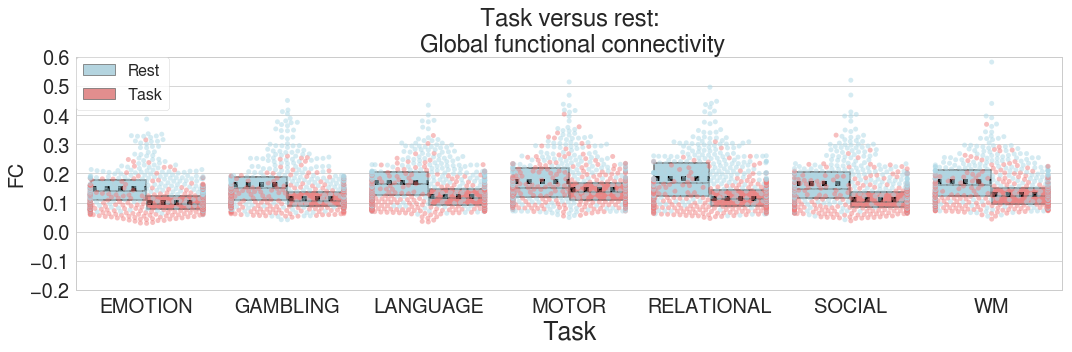

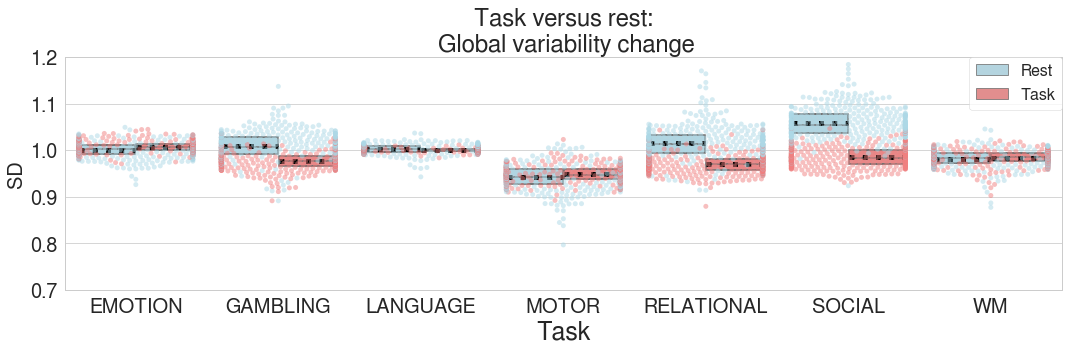

In [11]:
df_stat = {}
df_stat['Task'] = []
df_stat['Subject'] = []
df_stat['FC'] = []
df_stat['SD'] = []
df_stat['State'] = []
# df_stat['FC change'] = []
# df_stat['SD change'] = []
taskcount = 0
for task in taskNames:
    # Perform a Group-level analysis; average across all tasks
    taskfc_avg = np.mean(np.mean(taskFC[:,:,taskcount,:],axis=1),axis=0) # Compute average correlation for each subject
    restfc_avg = np.mean(np.mean(restFC[:,:,taskcount,:],axis=1),axis=0)
    fcstats = np.zeros((3,)) # avg r, t, p
    fcstats[0] = np.mean(taskfc_avg-restfc_avg)
    fcstats[1],fcstats[2] = stats.ttest_rel(taskfc_avg,restfc_avg)
    print 'Task', task
    print '\tAverage correlation difference between task versus rest:', fcstats[0]
    print '\tTask vs. Rest average FC difference: t =', fcstats[1], '| p =', fcstats[2]

    taskSD_avg = np.mean(taskSD[:,taskcount,:],axis=0)
    restSD_avg = np.mean(restSD[:,taskcount,:],axis=0)
    # taskSD_avg = np.mean(taskSD,axis=0)
    # restSD_avg = np.mean(restSD,axis=0)
    sdstats = np.zeros((3,))
    sdstats[0] = np.mean(taskSD_avg-restSD_avg)
    sdstats[1],sdstats[2] = stats.ttest_rel(taskSD_avg,restSD_avg)
    print '\tAverage SD difference between task versus rest:', sdstats[0]
    print '\tTask vs. Rest average SD difference: t =', sdstats[1], '| p =', sdstats[2]

    ## Plot
#     df_stat = {}
#     df_stat['Task'] = []
#     df_stat['Subject'] = []
#     df_stat['FC'] = []
#     df_stat['SD'] = []
#     df_stat['State'] = []

    # For rest state
    df_stat['Task'].extend(np.repeat(task,len(subjNums)))
    df_stat['State'].extend(np.repeat('Rest',len(subjNums)))
    df_stat['Subject'].extend(subjNums)
    df_stat['FC'].extend(restfc_avg)
    df_stat['SD'].extend(restSD_avg)
    # For task state
    df_stat['Task'].extend(np.repeat(task,len(subjNums)))
    df_stat['State'].extend(np.repeat('Task',len(subjNums)))
    df_stat['Subject'].extend(subjNums)
    df_stat['FC'].extend(taskfc_avg)
    df_stat['SD'].extend(taskSD_avg)
    # Task rest change
#     df_stat['FC change'].extend(taskfc_avg-restfc_avg)
#     df_stat['SD change'].extend(taskSD_avg-restSD_avg)
    
#     df_stat = pd.DataFrame(df_stat)



#     # Draw a nested boxplot to show bills by day and time
#     plt.figure(figsize=(10,5))
#     plt.subplot(121)
#     plt.title(task + ' task versus rest:\n Global functional connectivity',fontname='FreeSans',fontsize=24)
#     sns.boxplot(x="State",y="FC",
#                palette=["#add8e6","#f08080"],data=df_stat,
#                meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
#                medianprops={'linestyle':'-'},sym='',whis=0)
#     sns.swarmplot(x="State",y="FC",
#                 palette=["#add8e6","#f08080"],
#                 data=df_stat,alpha=0.5)
#     plt.ylabel('Whole-brain correlation',fontsize=20, fontname='FreeSans')
#     plt.xlabel('State', fontsize=20,fontname='FreeSans')
#     plt.ylim([np.min(df_stat['FC'])-np.std(df_stat['FC']),np.max(df_stat['FC'])+3*np.std(df_stat['FC'])]);
#     plt.xticks(fontsize=20,fontname='FreeSans')

#     plt.subplot(122)
#     plt.title(task + ' task versus rest:\nGlobal variability',fontname='FreeSans',fontsize=24)
#     sns.boxplot(x="State",y="SD",data=df_stat,
#                palette=["#add8e6","#f08080"],
#                meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
#                medianprops={'linestyle':'-'},sym='',whis=0)
#     sns.swarmplot(x="State",y="SD",
#                 palette=["#add8e6","#f08080"],
#                 data=df_stat,alpha=0.5)
#     plt.ylabel('Whole-brain SD',fontsize=20, fontname='FreeSans')
#     plt.xlabel('State', fontsize=20,fontname='FreeSans')
#     plt.xticks(fontsize=18,fontname='FreeSans')
#     plt.ylim([np.min(df_stat['SD'])-np.std(df_stat['SD']),np.max(df_stat['SD'])+3*np.std(df_stat['SD'])]);
#     plt.tight_layout()
#     plt.savefig('fMRI3_' + task + '_WholeBrainFCandSD_TaskVRest_Exploratory.pdf')
    
    taskcount += 1
    
    
df_stat = pd.DataFrame(df_stat)

plt.figure(figsize=(15,5))
plt.title('Task versus rest:\n Global functional connectivity',fontname='FreeSans',fontsize=24)
plt.ylabel('Whole-brain correlation change',fontsize=20, fontname='FreeSans')
plt.xlabel('Task', fontsize=25,fontname='freesans')
# plt.ylim([np.min(df_stat['FC'])-np.std(df_stat['FC']),np.max(df_stat['FC'])+3*np.std(df_stat['FC'])]);
sns.boxplot(x="Task",y="FC", hue="State", hue_order=['Rest','Task'],
           palette=["#add8e6","#f08080"],data=df_stat,
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
ax = sns.swarmplot(x="Task",y="FC", hue="State", hue_order=['Rest','Task'],
            palette=["#add8e6","#f08080"],
            data=df_stat,alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],borderaxespad=0.,fontsize=16)
plt.xticks(fontsize=20,fontname='FreeSans')
plt.yticks(fontsize=20,fontname='FreeSans')
plt.ylim([-.2,.6])
plt.tight_layout()
plt.savefig('fMRI3_7Task_WholeBrain_TaskVRest_FCChange.pdf')

plt.figure(figsize=(15,5))
plt.title('Task versus rest:\n Global variability change',fontname='FreeSans',fontsize=24)
plt.ylabel('Whole-brain variability change',fontsize=20, fontname='FreeSans')
plt.xlabel('Task', fontsize=25,fontname='freesans')
# plt.ylim([np.min(df_stat['FC'])-np.std(df_stat['FC']),np.max(df_stat['FC'])+3*np.std(df_stat['FC'])]);
sns.boxplot(x="Task",y="SD", hue="State", hue_order=['Rest','Task'],
           palette=["#add8e6","#f08080"],data=df_stat,
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
ax = sns.swarmplot(x="Task",y="SD", hue="State", hue_order=['Rest','Task'],
            palette=["#add8e6","#f08080"],
            data=df_stat,alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],borderaxespad=0.,fontsize=16)
plt.xticks(fontsize=20,fontname='FreeSans')
plt.yticks(fontsize=20,fontname='FreeSans')
plt.ylim([.7,1.2])
plt.tight_layout()
plt.savefig('fMRI3_7Task_WholeBrain_TaskVRest_SDChange.pdf')

## Compute the GBC and variability of each region during task versus rest, and visualize on the surface

Task: EMOTION
	Percent of SD Increases: 42.77777777777778
	Number of SD Decreases: 0.2777777777777778
	Pos-Neg Ratio = 154.0
Task: GAMBLING
	Percent of SD Increases: 5.555555555555555
	Number of SD Decreases: 71.66666666666667
	Pos-Neg Ratio = 0.07751937984496124
Task: LANGUAGE
	Percent of SD Increases: 0.2777777777777778
	Number of SD Decreases: 12.222222222222221
	Pos-Neg Ratio = 0.02272727272727273
Task: MOTOR
	Percent of SD Increases: 39.44444444444444
	Number of SD Decreases: 5.833333333333333
	Pos-Neg Ratio = 6.761904761904762
Task: RELATIONAL
	Percent of SD Increases: 0.0
	Number of SD Decreases: 93.33333333333333
	Pos-Neg Ratio = 0.0
Task: SOCIAL
	Percent of SD Increases: 0.0
	Number of SD Decreases: 99.44444444444444
	Pos-Neg Ratio = 0.0
Task: WM
	Percent of SD Increases: 35.27777777777778
	Number of SD Decreases: 24.166666666666668
	Pos-Neg Ratio = 1.4597701149425286


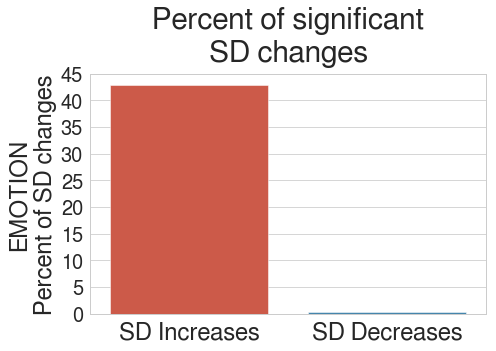

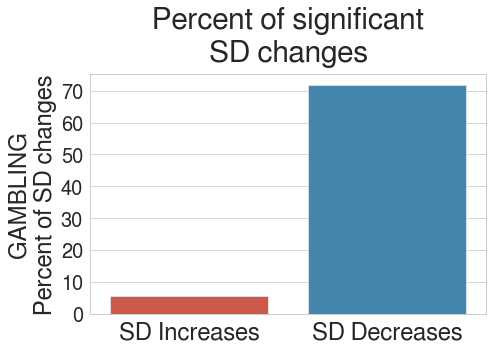

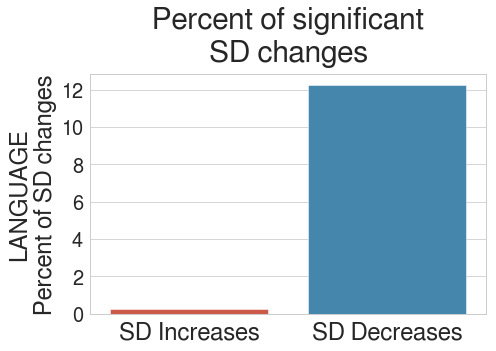

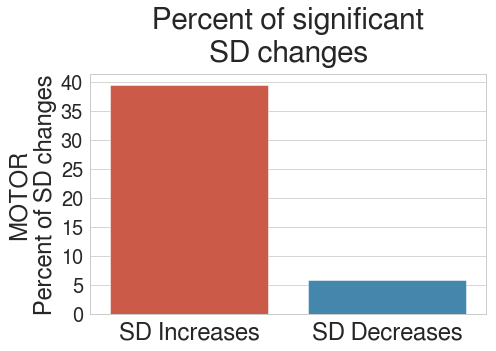

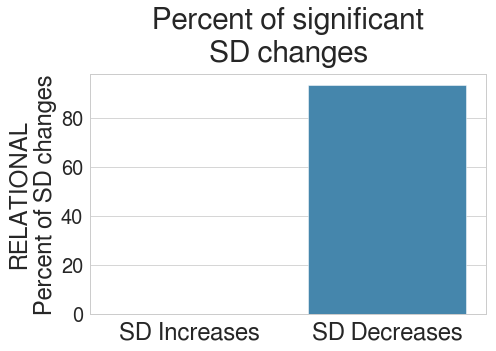

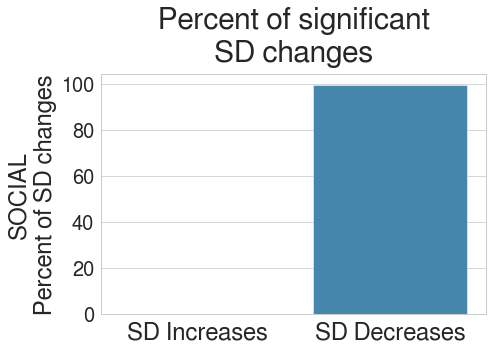

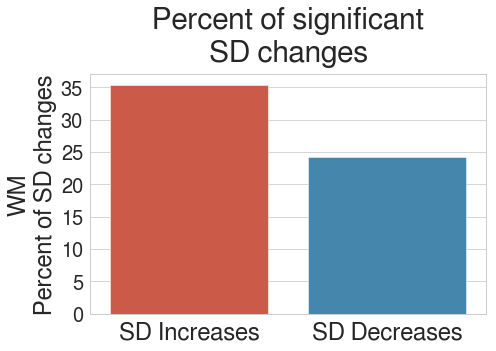

In [12]:
taskcount = 0
for task in taskNames:
    task_ind = tasks[task]

    fcByROI = np.zeros((glasser2.shape[0],4)) # fc diff, t, p, q
    sdByROI = np.zeros((glasser2.shape[0],4)) # sd diff, t, p, q
    actByROI = np.zeros((glasser2.shape[0],4)) # act diff, t, p, q
    fcdiff = taskFC - restFC
    sddiff = taskSD - restSD

    ps_fc = []
    ps_sd = []
    ps_act = []

    for roi in range(nParcels):
        roi_ind = np.where(glasser2==roi+1)[0]

        tmp = np.mean(fcdiff[roi,:,taskcount,:],axis=0)
        t, p = stats.ttest_1samp(tmp,0)
#         t, p = stats.ttest_1samp(fcdiff[roi,:,taskcount,:],axis=1)
        fcByROI[roi_ind,0] = np.mean(tmp)
        fcByROI[roi_ind,1] = t
        fcByROI[roi_ind,2] = p
        ps_fc.append(p)

        tmp = sddiff[roi,taskcount,:]
        t, p = stats.ttest_1samp(tmp,0)
        sdByROI[roi_ind,0] = np.mean(tmp)
        sdByROI[roi_ind,1] = t
        sdByROI[roi_ind,2] = p
        ps_sd.append(p)

        tmp = np.mean(taskActivity[roi,task_ind,:],axis=0)
        t, p = stats.ttest_1samp(tmp,0)
        actByROI[roi_ind,0] = np.mean(tmp)
        actByROI[roi_ind,1] = t
        actByROI[roi_ind,2] = p
        ps_act.append(p)

    qs_fc = mc.fdrcorrection0(ps_fc)[1]
    qs_sd = mc.fdrcorrection0(ps_sd)[1]
    qs_act = mc.fdrcorrection0(ps_act)[1]

    for roi in range(nParcels):
        roi_ind = np.where(glasser2==roi+1)[0]

        fcByROI[roi_ind,3] = qs_fc[roi]
        tmp = qs_fc[roi] < 0.05
        fcByROI[roi_ind,0] = np.multiply(fcByROI[roi_ind,0],tmp)
        fcByROI[roi_ind,1] = np.multiply(fcByROI[roi_ind,1],tmp)

        sdByROI[roi_ind,3] = qs_sd[roi]
        tmp = qs_sd[roi] < 0.05
        sdByROI[roi_ind,0] = np.multiply(sdByROI[roi_ind,0],tmp)
        sdByROI[roi_ind,1] = np.multiply(sdByROI[roi_ind,1],tmp)

        actByROI[roi_ind,3] = qs_act[roi]
        tmp = qs_act[roi] < 0.05
        actByROI[roi_ind,0] = np.multiply(actByROI[roi_ind,0],tmp)
        actByROI[roi_ind,1] = np.multiply(actByROI[roi_ind,1],tmp)
        
        
    ## Plot SD Difference for each task
    tmp = np.mean(sddiff[:,taskcount,:],axis=1)
    posSD = np.sum(np.multiply(tmp>0,qs_sd<0.05))/float(nParcels)*100
    negSD = np.sum(np.multiply(tmp<0,qs_sd<0.05))/float(nParcels)*100


    print 'Task:', task
    print '\tPercent of SD Increases:', posSD
    print '\tNumber of SD Decreases:', negSD
    print '\tPos-Neg Ratio =', posSD/negSD

    plt.figure(figsize=(7,5))
    sns.barplot(x=np.arange(2),y=[posSD,negSD])
    plt.xticks(np.arange(2),['SD Increases', 'SD Decreases'],fontsize=24)
    plt.ylabel(task + '\nPercent of SD changes',fontsize=24)
    plt.yticks(fontsize=20)
    plt.title('Percent of significant\nSD changes', y=1.03,fontsize=30)
    plt.tight_layout()
    plt.savefig('fMRI3_' + task + '_NumberSDChanges_Exploratory.pdf')
    
    
    ### Plot to workbench
    # Compute effect size baseline (information content)
    outdir = '/projects3/TaskFCMech/data/results/fMRI_FC_SD_Glasser/'
    filename = task + '_TaskVRest_FC_64k_EXPLORATORY_' + model
    np.savetxt(outdir + filename + '.csv', fcByROI,fmt='%s')
    wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + filename + '.dscalar.nii -reset-scalars'
    os.system(wb_command)

    # Compute effect size baseline (information content)
    outdir = '/projects3/TaskFCMech/data/results/fMRI_FC_SD_Glasser/'
    filename = task + '_TaskVRest_SD_64k_EXPLORATORY_' + model
    np.savetxt(outdir + filename + '.csv', sdByROI,fmt='%s')
    wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + filename + '.dscalar.nii -reset-scalars'
    os.system(wb_command)

    # Compute effect size baseline (information content)
    outdir = '/projects3/TaskFCMech/data/results/fMRI_FC_SD_Glasser/'
    filename = task + '_TaskVRest_Activity_64k_EXPLORATORY_' + model
    np.savetxt(outdir + filename + '.csv', actByROI,fmt='%s')
    wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + filename + '.dscalar.nii -reset-scalars'
    os.system(wb_command)
    
    taskcount += 1

# Correlate if regions with more evoked activity are associated with more decreases in FC/variability (at group-level)

## Correlate task activity with SD reduction across regions
##### This is a replication of He et al. (2013)

In [22]:
ps

[0.014861128304901928,
 4.046895099150166e-05,
 9.19602648152083e-06,
 0.24793313613135431,
 4.974598478380294e-09,
 0.05111871859273372,
 0.00018341528693009874]

In [23]:
qs

array([2.08055796e-02, 9.44275523e-05, 3.21860927e-05, 2.47933136e-01,
       3.48221893e-08, 5.96385050e-02, 3.20976752e-04])

In [24]:
rhos

[-0.1282903417464641,
 -0.21456261236583615,
 0.23138372981273,
 -0.06104959657610527,
 -0.30204013919860495,
 -0.10288428151451785,
 -0.1959261516935573]

Task: EMOTION
	rho = -0.12803853939202206 | q = 0.017570379905250604
	SD Reduction: 0.006830676364030255
	Activity-level: 0.8262476478971278
Task: GAMBLING
	rho = -0.2394272589551874 | q = 7.6093784952077416e-06
	SD Reduction: -0.032145406879036935
	Activity-level: 0.8262476478971278
Task: LANGUAGE
	rho = 0.2126852830654557 | q = 6.63793416068011e-05
	SD Reduction: -0.001602636769407393
	Activity-level: 0.8262476478971278
Task: MOTOR
	rho = -0.47984552349940973 | q = 2.7616550532251844e-21
	SD Reduction: 0.0070858595033004785
	Activity-level: 0.8262476478971278
Task: RELATIONAL
	rho = -0.3458020509417511 | q = 5.260662474167833e-11
	SD Reduction: -0.04478198244448636
	Activity-level: 0.8262476478971278
Task: SOCIAL
	rho = -0.1226331478895156 | q = 0.019938681179520034
	SD Reduction: -0.07261842994709297
	Activity-level: 0.8262476478971278
Task: WM
	rho = -0.25334891987335295 | q = 2.6050274249341054e-06
	SD Reduction: 0.0018102564834784791
	Activity-level: 0.8262476478971278


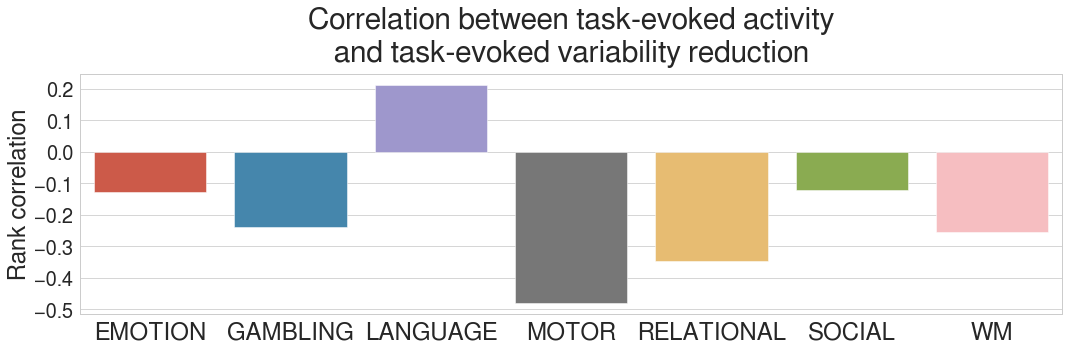

In [26]:
ps = []
rhos = []
taskcount = 0
for task in taskNames:
    task_ind = tasks[task]
    tmp_sddiff = np.zeros((360,2))
    tmp_act = np.zeros((360,2))
    for roi in range(360):
        tmp = taskSD[roi,taskcount,:] - restSD[roi,taskcount,:]
        t, p = stats.ttest_1samp(tmp,0)
        tmp_sddiff[roi,0] = np.mean(tmp)
        tmp_sddiff[roi,1] = t
#
#         t = np.abs(stats.ttest_1samp(np.mean(taskActivity[roi,task_ind,:],axis=0),0,axis=0)[0])
        t = np.mean(np.abs(stats.ttest_1samp(taskActivity[roi,task_ind,:],0,axis=1)[0]),axis=0)
        tmp_act[roi,0] = np.mean(taskActivity[roi,:,:])
        tmp_act[roi,1] = t
        
    r, p = stats.spearmanr(tmp_sddiff[:,0],tmp_act[:,1])
    rhos.append(r)
    ps.append(p)
    
    taskcount += 1

qs = mc.fdrcorrection0(ps)[1]

actXsd_corr = []
taskcount = 0
for task in taskNames:
    task_ind = tasks[task]
    tmp_sddiff = np.zeros((360,2))
    tmp_act = np.zeros((360,2))
    for roi in range(360):
        tmp = taskSD[roi,taskcount,:] - restSD[roi,taskcount,:]
        t, p = stats.ttest_1samp(tmp,0)
        tmp_sddiff[roi,0] = np.mean(tmp)
        tmp_sddiff[roi,1] = t

#         t = np.abs(stats.ttest_1samp(np.mean(taskActivity[roi,task_ind,:],axis=0),0,axis=0)[0])
        t = np.mean(np.abs(stats.ttest_1samp(taskActivity[roi,task_ind,:],0,axis=1)[0]),axis=0)
        tmp_act[roi,0] = np.mean(taskActivity[roi,:,:])
        tmp_act[roi,1] = t
        
    r, p = stats.spearmanr(tmp_sddiff[:,0],tmp_act[:,1])
    actXsd_corr.append(r)
    print 'Task:', task
    print '\trho =', r, '| q =', qs[taskcount] 
    print '\tSD Reduction:', np.mean(tmp_sddiff[:,0],axis=0)
    print '\tActivity-level:', np.mean(tmp_act[:,0],axis=0)

    networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                      'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
    networkpalette = np.asarray(networkpalette)
    tmp = {}
    netcount = 0
    for network in orderednetworks:
        net = np.where(networkdef==networkmappings[network])[0]
        for roi in net:
            tmp[roi] = networkpalette[netcount]
        netcount += 1

    roiColorsByNetwork = []
    for roi in range(len(networkdef)):
        roiColorsByNetwork.append(tmp[roi])


#     plt.figure(figsize=(7,5))
#     sns.regplot(tmp_act[:,1],tmp_sddiff[:,1],color='k')
#     sns.regplot(tmp_act[:,1],tmp_sddiff[:,1],color='k',scatter_kws={'color':roiColorsByNetwork})
#     plt.xlabel('Task activation t-statistic\n(abs. value)',fontsize=20)
#     plt.ylabel('SD change\n(task vs. rest)',fontsize=20)
#     plt.title(task + '\nTask-evoked activity and variability\nare negatively correlated',fontsize=25)
#     plt.xticks(fontsize=18)
#     plt.yticks(fontsize=18)
#     plt.tight_layout()
#     plt.savefig('fMRI3_' + task + '_ActivityXSD_RegionalCorrelation_Exploratory.pdf')
    
    taskcount += 1
    

plt.figure(figsize=(15,5))
sns.barplot(x=np.arange(len(actXsd_corr)),y=actXsd_corr)
plt.xticks(np.arange(len(taskNames)),taskNames,fontsize=24)
plt.ylabel('Rank correlation',fontsize=24)
plt.yticks(fontsize=20)
plt.title('Correlation between task-evoked activity\nand task-evoked variability reduction', y=1.03,fontsize=30)
plt.tight_layout()
plt.savefig('fMRI3_ActivityXSD_SpatialCorrelation.pdf')

# Correlation

Task: EMOTION
	rho = -0.12555189469054542 | q = 0.0300241639228219
	FC Reduction: -0.04356374109665949
	Activity-level: 8.189600201630935
Task: GAMBLING
	rho = -0.2640220989359485 | q = 2.6073570727594895e-06
	FC Reduction: -0.04356374109665949
	Activity-level: 8.189600201630935
Task: LANGUAGE
	rho = 0.2233221964161246 | q = 4.93304642988628e-05
	FC Reduction: -0.04356374109665949
	Activity-level: 8.189600201630935
Task: MOTOR
	rho = -0.11810276313860445 | q = 0.035045826346630636
	FC Reduction: -0.04356374109665949
	Activity-level: 8.189600201630935
Task: RELATIONAL
	rho = -0.07081716165505392 | q = 0.2100314813018625
	FC Reduction: -0.04356374109665949
	Activity-level: 8.189600201630935
Task: SOCIAL
	rho = 0.02398501017240359 | q = 0.6501411240043178
	FC Reduction: -0.04356374109665949
	Activity-level: 8.189600201630935
Task: WM
	rho = -0.22209250585781265 | q = 4.93304642988628e-05
	FC Reduction: -0.04356374109665949
	Activity-level: 8.189600201630935


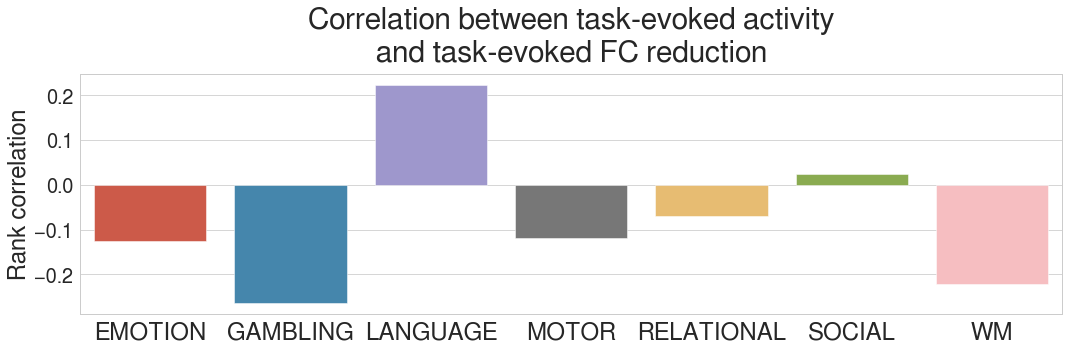

In [28]:
actXfc_corr = []
ps = []
taskcount = 0
for task in taskNames:
    task_ind = tasks[task]
    tmp_fcdiff = np.zeros((360,2))
    tmp_act = np.zeros((360,2))
    for roi in range(360):
        tmp = np.mean(taskFC[roi,:,taskcount,:],axis=0) - np.mean(restFC[roi,:,taskcount,:],axis=0)
    #     tmp = stats.ttest_1samp(taskGeneralFC[roi,:,:],0,axis=0)[0] - stats.ttest_1samp(restGeneralFC[roi,:,:],0,axis=0)[0]
    #     tmp = stats.ttest_rel(tmp[roi,:,:],0-,axis=0)[0] 

        t, p = stats.ttest_1samp(tmp,0)
        tmp_fcdiff[roi,0] = np.mean(tmp)
        tmp_fcdiff[roi,1] = t

#         t = np.abs(stats.ttest_1samp(np.mean(taskActivity[roi,task_ind,:],axis=0),0,axis=0)[0])
        t = np.mean(np.abs(stats.ttest_1samp(taskActivity[roi,task_ind,:],0,axis=1)[0]),axis=0)
        tmp_act[roi,0] = np.mean(taskActivity[roi,taskcount,:])
        tmp_act[roi,1] = t
    r, p = stats.spearmanr(tmp_fcdiff[:,0],tmp_act[:,1])
    actXfc_corr.append(r)
    ps.append(p)
    
    taskcount += 1

qs = mc.fdrcorrection0(ps)[1]
taskcount = 0
for task in taskNames:
    print 'Task:', task
    print '\trho =', actXfc_corr[taskcount], '| q =', qs[taskcount] 
    print '\tFC Reduction:', np.mean(tmp_fcdiff[:,0],axis=0)
    print '\tActivity-level:', np.mean(tmp_act[:,0],axis=0)

#     plt.figure(figsize=(7,5))
#     sns.regplot(tmp_act[:,1],tmp_fcdiff[:,0],color='k')
#     sns.regplot(tmp_act[:,1],tmp_fcdiff[:,0],color='k',scatter_kws={'color':roiColorsByNetwork})
#     plt.xlabel('Task activation t-statistic\n(abs. value)',fontsize=20)
#     plt.ylabel('FC change\n(task vs. rest)',fontsize=20)
#     plt.title(task + '\nTask-evoked activity and FC\nare negatively correlated',fontsize=25)
#     plt.xticks(fontsize=18)
#     plt.yticks(fontsize=18)
#     plt.tight_layout()
#     plt.savefig('fMRI3_' + task + '_ActivityXFC_RegionalCorrelation_Exploratory.pdf')
    
    taskcount += 1
    
    
plt.figure(figsize=(15,5))
sns.barplot(x=np.arange(len(actXfc_corr)),y=actXfc_corr)
plt.xticks(np.arange(len(taskNames)),taskNames,fontsize=24)
plt.ylabel('Rank correlation',fontsize=24)
plt.yticks(fontsize=20)
plt.title('Correlation between task-evoked activity\nand task-evoked FC reduction', y=1.03,fontsize=30)
plt.tight_layout()
plt.savefig('fMRI3_ActivityXFC_SpatialCorrelation.pdf')